# Batch normalization
In this chapter we will add batch normalization to the layers, so the model will learn faster.

In [30]:
import zipfile
import os
import cv2
import pandas as pd
from os import chdir, listdir

import matplotlib.pyplot as plt
import numpy as np
import random

import tensorflow as tf
from tensorflow.keras import layers, models, preprocessing
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.losses import MeanSquaredError

# Import zip with the data
The data is imported as a zip from the github of our project group. The zip is unpacked in the google colab, so the data is accesible. 

In [2]:
# Code from: https://towardsdatascience.com/an-informative-colab-guide-to-load-image-datasets-from-github-kaggle-and-local-machine-75cae89ffa1e

# Get zip file from Github URL
!wget --no-check-certificate \
    "https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip" \
    -O "/tmp/pawpularity_data.zip"

# Opens the zip file in read mode and extract files into /tmp folder
zip_ref = zipfile.ZipFile('/tmp/pawpularity_data.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2022-01-19 12:00:56--  https://github.com/ilsefeenstra/Fitgirls0011/archive/refs/heads/main.zip
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main [following]
--2022-01-19 12:00:57--  https://codeload.github.com/ilsefeenstra/Fitgirls0011/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘/tmp/pawpularity_data.zip’

/tmp/pawpularity_da     [              <=>   ] 987.37M  22.2MB/s    in 46s     

2022-01-19 12:01:43 (21.4 MB/s) - ‘/tmp/pawpularity_data.zip’ saved [1035329331]



# Import tabular data

The tabular data is imported. This contains information on whether several elements are present in the image, such as blur, a human, a group, etc. Also the pawpularity score of the training data is in the table. For the test data only the image ID and the features are in the table. There is also a sample submission table, which contains the pawpularity score for the test data.

In [3]:
# Import the CSV tables
csv_train_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train.csv")
csv_test_data = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test.csv")
sample_submission = pd.read_csv("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/sample_submission.csv")
csv_train_data.head()

# Drop rows with missing values (if NaN values are in dataframe)
# No missing values present, so no samples dropped
csv_train_data.dropna()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,0007de18844b0dbbb5e1f607da0606e0,0,1,1,1,0,0,1,0,0,0,0,0,63
1,0009c66b9439883ba2750fb825e1d7db,0,1,1,0,0,0,0,0,0,0,0,0,42
2,0013fd999caf9a3efe1352ca1b0d937e,0,1,1,1,0,0,0,0,1,1,0,0,28
3,0018df346ac9c1d8413cfcc888ca8246,0,1,1,1,0,0,0,0,0,0,0,0,15
4,001dc955e10590d3ca4673f034feeef2,0,0,0,1,0,0,1,0,0,0,0,0,72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9907,ffbfa0383c34dc513c95560d6e1fdb57,0,0,0,1,0,0,0,0,0,0,0,1,15
9908,ffcc8532d76436fc79e50eb2e5238e45,0,1,1,1,0,0,0,0,0,0,0,0,70
9909,ffdf2e8673a1da6fb80342fa3b119a20,0,1,1,1,0,0,0,0,1,1,0,0,20
9910,fff19e2ce11718548fa1c5d039a5192a,0,1,1,1,0,0,0,0,1,0,0,0,20


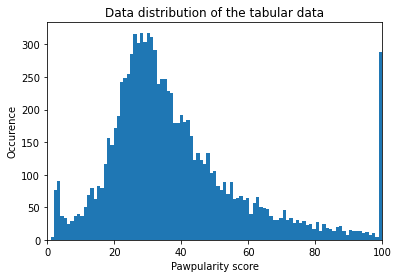

In [4]:
# Create a plot that shows the distribution of the output of the training samples
plt.hist(csv_train_data['Pawpularity'], bins=100)
plt.title("Data distribution of the tabular data")
plt.xlabel("Pawpularity score")
plt.ylabel("Occurence")
plt.xlim(0, 100)

plt.show()

# Import image data
The images are imported from the folders. Each image is reshaped to a 64x64 image. In this way all the images have the same shape and we do not use much memory, to speed up analysis. After the images are imported, the images and their names are shuffled. This is done, so we can later take a validation sample containing a random subsample of the dataset. It could be that the images in the dataset contain some order, so by shuffling we ensure that the subset for the validation data is random.


In [5]:
def reshape_images(path, n):
    """
    This function returns a list of images, which are reshaped to 64 x 64 
    and a list with the names of the images.
    """
    # Set the current path
    chdir(path)
    
    # Preset the lists
    images = []
    image_names = []
    
    # Go over all the files in the path
    for i in listdir():
        
        # Get the name of the image, without .jpg
        image_names.append(i[:-4])
        
        # Get the image and reshape to n x n
        file = cv2.imread(i)
        file = cv2.resize(file,(n, n), interpolation=cv2.INTER_AREA)
        
        # Rescale the pixels and store in the list
        images.append(file/255)
        
    return images, image_names

# Reshape train and test images
train_imgs, train_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/train", 64)
test_imgs, test_names = reshape_images("/tmp/Fitgirls0011-main/petfinder-pawpularity-score/test", 64)

In [6]:
# Zip train image data and names
combined = list(zip(train_imgs, train_names))

# Make sure shuffle is the same each time
random.seed(4)

# Shuffle the image data
random.shuffle(combined)

# Unzip the train images and names
train_imgs, train_names = zip(*combined)

# Combine tabular data with images
To ensure that the dataframe has the same order as the images in the list, we sort the dataframe based on the names of the images. If this would not be the case, it could be that you learn incorrectly, as the output of an image perhaps is not the real output.

In [7]:
def sort_dataframe(data, images, names):
    """
    This function sorts the dataframe of the csv data according to the image names.
    """
    data_sorted = pd.DataFrame()

    # Iterate over images and get index of each image
    for img, name in zip(images, names):
        location = data[data['Id'] == name].index[0]

        # Sort dataframe according to index of images
        data_sorted = data_sorted.append([data.loc[location]])

        # Reset the index of the dataframe
        data_sorted = data_sorted.reset_index().drop(['index'],axis=1)
        
    return data_sorted

# Sort training and testing data
train_data_sorted = sort_dataframe(csv_train_data, train_imgs, train_names)
test_data_sorted = sort_dataframe(csv_test_data, test_imgs, test_names)
sample_submission_sorted = sort_dataframe(sample_submission, test_imgs, test_names)

train_data_sorted.head()

,Id,Subject Focus,Eyes,Face,Near,Action,Accessory,Group,Collage,Human,Occlusion,Info,Blur,Pawpularity
0,38f19ceba149ba0bbc1602211e24c14b,0,1,1,1,0,0,0,0,1,1,0,0,87
1,a1ece3037f353dced1f1b3257b1fb891,0,1,1,1,0,0,0,0,0,0,0,0,50
2,a688976b47df3243167b4ffa9a0128fc,0,0,0,1,0,0,0,0,0,0,0,0,45
3,f5cc76e712921ed08038d6801bb1808a,0,0,0,0,0,0,0,0,0,0,0,0,30
4,282a949413dd82a756c96dfdfe9fbc62,0,1,1,1,0,0,0,1,0,0,1,0,98


# Processing data
First we split the data in a train and validation set, where 20% of the data is put in the validation set. Then the image data is converted to numpy arrays, so they can be used in the neural networks. The tabular data is split in the x and y values and also converted to numpy arrays.

In [8]:
# split the dataset into training and validation set
split_threshold = int(0.2 * len(train_names))

val_tabular = train_data_sorted[:split_threshold]
train_tabular = train_data_sorted[split_threshold:]

val_images = train_imgs[:split_threshold]
train_images = train_imgs[split_threshold:]

In [9]:
# Make numpy arrays of images for further analysis
train_imgs_array = np.array(train_images)
val_imgs_array = np.array(val_images)
test_imgs_array = np.array(test_imgs)

In [10]:
# Select x (the 12 input features) and y (pawpularity) values from training data
x_train_tabular = train_tabular.iloc[:,1:13].to_numpy()
y_train = train_tabular.iloc[:,13].to_numpy()

# Select x (the 12 input features) and y (pawpularity) values from validation data
x_val_tabular = val_tabular.iloc[:,1:13].to_numpy()
y_val = val_tabular.iloc[:,13].to_numpy()

# Select x (the 12 input features) and y (pawpularity) values from testing data
x_test_tabular = test_data_sorted.iloc[:,1:13].to_numpy()
y_test = sample_submission_sorted.iloc[:,1].to_numpy()

# Create seperate neural networks
We create a tabular neural network to handle the data in the csv. Then we create a convolutional neural network to handle the image data. Both neural networks have no output layer, since they will be concatenated to one neural network, which will give the output.

In [11]:
def build_neural_net(input_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number of 
    hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()

    # Create hidden layer with relu activations
    model.add(layers.Dense(units=hidden_nodes, activation='relu', input_shape=(input_size,)))    

    # Create hidden layer with relu activations
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=hidden_nodes, activation="relu"))

    # Create hidden layer with relu activations
    model.add(layers.Dropout(0.4))
    model.add(layers.Dense(units=hidden_nodes, activation="relu"))

    return model

# Create neural network for tabular data and get summary of model 
# with 12 inputs and 100 hidden nodes
tabular_NN = build_neural_net(12, hidden_nodes=20)
tabular_NN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 20)                260       
                                                                 
 dropout (Dropout)           (None, 20)                0         
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
Total params: 1,100
Trainable params: 1,100
Non-trainable params: 0
_________________________________________________________________


In [32]:
def build_convol_net(image_size, hidden_nodes):
    """
    Build neural network with an input size and a hidden layer with a number 
    of hidden nodes.
    """
    # Create a sequential model object
    model = models.Sequential()
    
    # Create a convolutional layer with relu activation
    model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=image_size, padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(layers.BatchNormalization())

    # Create a convolutional layer with relu activation
    model.add(layers.Dropout(.4))
    model.add(layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(layers.BatchNormalization())

    # Create a convolutional layer with relu activation
    model.add(layers.Dropout(.4))
    model.add(layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2,2), strides=2))
    model.add(layers.BatchNormalization())
    
    # Create a flattening layer
    model.add(layers.Flatten())

    # Create a dense layer with relu activations
    model.add(layers.Dropout(.3))
    model.add(layers.Dense(units=hidden_nodes, activation="relu"))

    # Create a dense layer with relu activations
    model.add(layers.Dropout(.3))
    model.add(layers.Dense(units=hidden_nodes, activation="relu"))
    
    return model

In [33]:
# Create neural network for image data and get summary of model
image_size = (64, 64, 3)
image_NN = build_convol_net(image_size, hidden_nodes=20)
image_NN.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 32, 32, 64)       0         
 g2D)                                                            
                                                                 
 dropout_30 (Dropout)        (None, 32, 32, 64)        0         
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 16, 16, 128)      0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 16, 16, 128)      

## Concatenate tabular and image data models
Concatenate the tabular and image models to create one neural network that can handle both types of data. This neural network will give the prediction of the pawpularity.

In [34]:
def concatenate_models(model1, model2, hidden_nodes):
    """
    Concatenate two neural network models, model1 and model2, and create
    a concatenated model with dense layers with some hidden nodes.
    """
    # Input for concatenated model is retrieved by concatenating the output
    # of both models
    concat_input = layers.concatenate([model1.output, model2.output])

    # Create hidden layer with relu activation
    hidden_layer_1 = layers.Dense(hidden_nodes, activation="relu")(concat_input)

    # Create hidden layer with relu activation
    drop_out_1 = layers.Dropout(.4)(hidden_layer_1)    
    hidden_layer_2 = layers.Dense(hidden_nodes, activation="relu")(drop_out_1)

    # Create hidden layer with relu activation
    drop_out_2 = layers.Dropout(.4)(hidden_layer_2)
    hidden_layer_3 = layers.Dense(hidden_nodes, activation="relu")(drop_out_2)

    # Create output layer
    output_layer = layers.Dense(1, activation="linear")(hidden_layer_3)

    # Create concatenated model with inputs of both models and output of the
    # concatenated model
    concat_model = models.Model(inputs=[model1.input, model2.input], outputs=output_layer)

    return concat_model

In [ ]:
# Part of code from: https://www.tensorflow.org/tutorials/keras/regression

def plot_loss(history):
    """
    Plot loss during epochs of training a neural network.
    """
    
    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'root_mean_squared_error']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

def train_and_evaluate(model, image_x, tabular_x, train_y, x_val_tabular, x_val_imgs, val_y, epochs=20, preprocess = {}, augment={}):
  """
  This function trains and evaluated a model. It first compiles the model with 
  the loss and metrics. It then makes a train and validation generator for the 
  image data, based on the preprocess and augment input. 
  It then trains the model on both the image and tabular data for epochs times. 
  The values of the loss and metric are plotted and printed.
  """

  # Compile model and use mean squared error as loss and root mean squared error as metric
  model.compile(loss=MeanSquaredError(), metrics=[RootMeanSquaredError()])

  # Preprocess the image data
  train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
  train_gen.fit(image_x)

  val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
  val_gen.fit(image_x)

  # Train the model by fitting both tabular and image data at the same time
  history = model.fit(train_gen.flow([image_x, tabular_x], train_y), epochs=epochs, 
                      validation_data=val_gen.flow([x_val_imgs, x_val_tabular], val_y))

  # Plot the loss and metric
  plot_loss(history)

  print(f"Validation Accuracy: {model.evaluate(val_gen.flow([x_val_imgs, x_val_tabular], val_y))[1]}")

# Concatenate tabular and image neural networks
concat_model = concatenate_models(image_NN, tabular_NN, hidden_nodes=20)

# Train model on both tabular and image data and preprocess
train_and_evaluate(concat_model, train_imgs_array, x_train_tabular, y_train, 
                   x_val_tabular, val_imgs_array, y_val,
                   preprocess={'featurewise_center': True, 'featurewise_std_normalization': True}, epochs=60)

# See how the model scored on the testing data
loss = concat_model.evaluate([test_imgs_array, x_test_tabular], y_test)
print(f'Test loss: {loss}')


losses [842.14978 464.90802 22.4484348 ... 19.5595417 682.02948 64.5682144]
losses [449.677032 974.165955 2410.46826 ... 171.107376 602.959839 2579.51172]
100/248 [===========>..................] - ETA: 5s - loss: 652.4032 - root_mean_squared_error: 25.5422losses [23.2743187 0.00244623795 1123.58911 ... 1005.76874 52.1285 2119.18213]
losses [1870.45557 108.4011 15.1724548 ... 153.352142 13.7228975 927.198]
102/248 [===========>..................] - ETA: 5s - loss: 651.9310 - root_mean_squared_error: 25.5329losses [435.671814 387.490112 433.25592 ... 614.877258 1418.49451 2925.31958]
losses [408.425262 159.739014 14.5021906 ... 185.605911 494.520111 809.58551]
104/248 [===========>..................] - ETA: 5s - loss: 657.2574 - root_mean_squared_error: 25.6370losses [25.0112743 682.702209 657.510925 ... 0.754099667 25.5778332 611.146667]
losses [356.750366 15.2109041 61.3897514 ... 222.458847 4.69839334 53.7890892]
106/248 [===========>..................] - ETA: 5s - loss: 653.8076 - r

KeyboardInterrupt: ignored

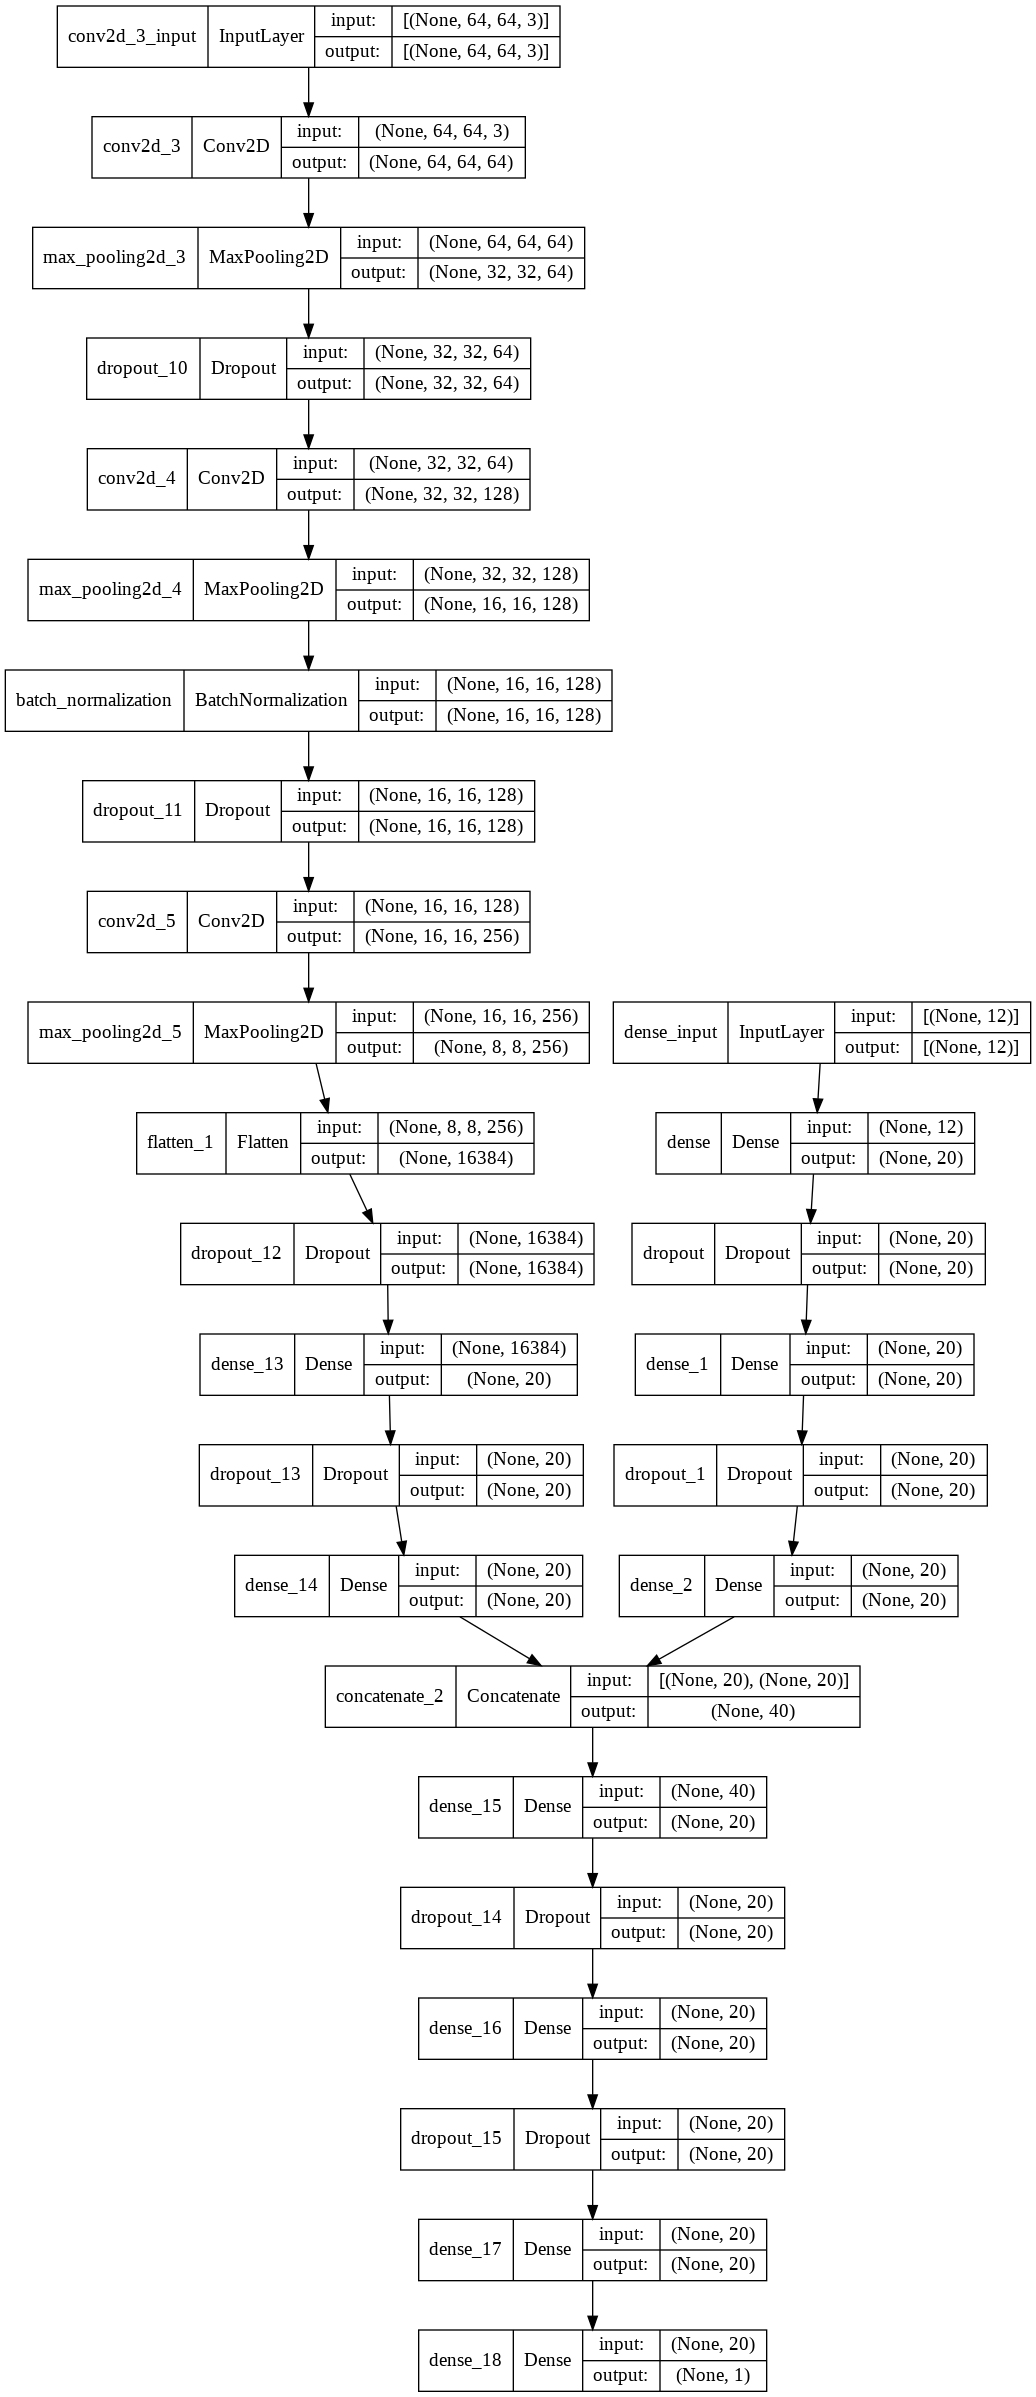

In [21]:
# Create overview of layers in model
tf.keras.utils.plot_model(concat_model, to_file='model.png', show_shapes=True, show_layer_names=True, rankdir='TB')